## 2. Gradient Descent

### 2.1 Load Llama and Pass Sample Text Through

In [1]:
import torch
from torch.nn import functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device='cuda'
model_id = "meta-llama/Llama-3.2-1B"

In [3]:
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

In [4]:
text = "The capital of France is"
inputs = tokenizer(text, return_tensors="pt").to(device)

In [5]:
inputs

{'input_ids': tensor([[128000,    791,   6864,    315,   9822,    374]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [6]:
#Tokenizer prepends a speical <|begin_of_text|> token
for input_token_index in inputs['input_ids'].view(-1):
    print(input_token_index.item(), tokenizer.decode(input_token_index))

128000 <|begin_of_text|>
791 The
6864  capital
315  of
9822  France
374  is


In [7]:
#Pass inputs into model
with torch.no_grad():
    outputs=model(inputs["input_ids"])

In [8]:
#One output vector for each input token, each vector has one value for each token in Llama's 128256 token vocabulary
outputs.logits.shape 

torch.Size([1, 6, 128256])

In [9]:
probabilities=F.softmax(outputs.logits, dim=-1) #Convert to probabilities (more on this in Ch. 3)
probabilities.shape

torch.Size([1, 6, 128256])

In [10]:
#Just look at final vector to see what text the model predicts next
top_probs, top_indices = torch.topk(probabilities[0, -1, :], 10)
for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
    print(idx.item(), round(probabilities[0, -1, idx].item(),5), tokenizer.decode([idx]))

12366 0.39153  Paris
264 0.08419  a
279 0.0704  the
832 0.03096  one
1101 0.03061  also
2162 0.02528  home
3967 0.02462  known
539 0.01659  not
459 0.01241  an
7559 0.01172  located


In [11]:
# For comparison, here's the top results for the 4th position, 
# these are the models predictions after "The Capital of" - Interesting that France makes the top 10 list!
top_probs, top_indices = torch.topk(probabilities[0, 3, :], 10)
for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
    print(idx.item(), round(probabilities[0, 3, idx].item(),5), tokenizer.decode([idx]))

279 0.20471  the
1561 0.01653  New
6890 0.01426  India
4987 0.01425  South
9822 0.01127  France
5734 0.00979  China
8524 0.0095  Russia
18157 0.00935  Spain
12550 0.00887  Mexico
16272 0.00872  Georgia


### 2.2 How does our model's confidence in Paris change as we modify a specific weight?

In [12]:
param_dict = {name: param for name, param in model.named_parameters()}
len(param_dict) #Our llama model contains 146 separate parameter tensors

146

In [13]:
#Quick look at the sizes of the first tensors
for k, v in list(param_dict.items())[:16]:
    print(k, v.shape)

model.embed_tokens.weight torch.Size([128256, 2048])
model.layers.0.self_attn.q_proj.weight torch.Size([2048, 2048])
model.layers.0.self_attn.k_proj.weight torch.Size([512, 2048])
model.layers.0.self_attn.v_proj.weight torch.Size([512, 2048])
model.layers.0.self_attn.o_proj.weight torch.Size([2048, 2048])
model.layers.0.mlp.gate_proj.weight torch.Size([8192, 2048])
model.layers.0.mlp.up_proj.weight torch.Size([8192, 2048])
model.layers.0.mlp.down_proj.weight torch.Size([2048, 8192])
model.layers.0.input_layernorm.weight torch.Size([2048])
model.layers.0.post_attention_layernorm.weight torch.Size([2048])
model.layers.1.self_attn.q_proj.weight torch.Size([2048, 2048])
model.layers.1.self_attn.k_proj.weight torch.Size([512, 2048])
model.layers.1.self_attn.v_proj.weight torch.Size([512, 2048])
model.layers.1.self_attn.o_proj.weight torch.Size([2048, 2048])
model.layers.1.mlp.gate_proj.weight torch.Size([8192, 2048])
model.layers.1.mlp.up_proj.weight torch.Size([8192, 2048])


In [14]:
#We're going to modify a parameter in the final MLP layer
param_dict['model.layers.15.mlp.down_proj.weight'].shape 

torch.Size([2048, 8192])

In [15]:
#Print this parameters current value. 
initial_value=param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item()
initial_value

-0.007080078125

In [16]:
text = "The capital of France is"
inputs = tokenizer(text, return_tensors="pt").to(device)

In [17]:
#Sanity check that if replace our parameter with it's current value we get the same answer
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value
    with torch.no_grad():
        outputs=model(inputs["input_ids"])
    probs=F.softmax(outputs.logits.detach().cpu(), dim=-1)
    loss=-np.log(probs[0, -1, 12366].item()) #12366 is Paris token index
    print(param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item(), probs[0, 5, 12366].item(), loss)

-0.007080078125 0.391557902097702 0.9376218764087003


In [18]:
#Decrease our parameter, how does our models prediction change?
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value-0.01
    with torch.no_grad():
        outputs = model(inputs["input_ids"])
    probs=F.softmax(outputs.logits.detach().cpu(), dim=-1)
    loss=-np.log(probs[0, -1, 12366].item())
    print(param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item(), probs[0, 5, 12366].item(), loss)

-0.017080077901482582 0.39008358120918274 0.9413942520269462


In [19]:
#Increase our parameter, how does our models prediction change?
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value+0.01
    with torch.no_grad():
        outputs = model(inputs["input_ids"])
    probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
    loss=-np.log(probs[0, -1, 12366].item())
    print(param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item(), probs[0, 5, 12366].item(), loss)

0.0029199218843132257 0.3930262625217438 0.9338788435905439


In [20]:
# Now test range of values for our parameter
xs=np.arange(-1, 4, 0.01)
model.eval()
losses=[]; all_probs=[]
with torch.no_grad():
    for x in tqdm(xs):
        param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=x
        outputs = model(inputs["input_ids"])
        probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, -1, 12366])
        losses.append(my_loss.item())
        all_probs.append(probs[0, -1, 12366].item())

  0%|                                                               | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_2244611/1879869523.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, -1, 12366])
100%|█████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.21it/s]


Text(0.5, 0, 'Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

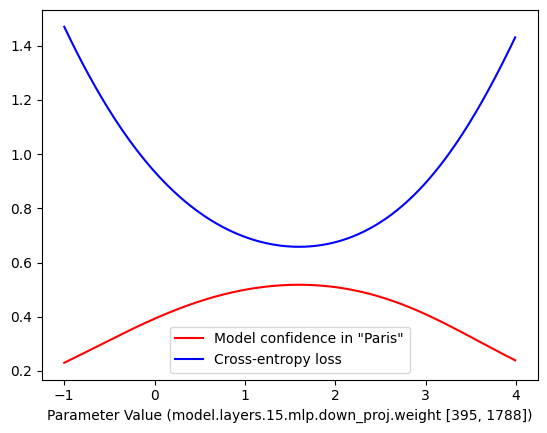

In [21]:
plt.plot(xs, all_probs, color='red'); plt.plot(xs, losses, color='blue')
plt.legend(['Model confidence in "Paris"', 'Cross-entropy loss'])
plt.xlabel('Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

In [22]:
#What paramter value minimizes our loss?
xs[np.argmin(losses).item()]

np.float64(1.5900000000000025)

In [23]:
#Return model to its original setup
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value

### 2.3 Let's Try Learning One Parameter At a Time

In [24]:
#Set our first parameter to the optimal value we found in 2.2
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=1.59

In [25]:
# Now test range of values for a second parameter
xs=np.arange(-1, 4, 0.01)
model.eval()
losses_2=[]; all_probs_2=[]
with torch.no_grad():
    for x in tqdm(xs):
        param_dict['model.layers.15.mlp.down_proj.weight'][1671, 1788]=x #Second parameter was also chosen due to high gradient.
        outputs = model(inputs["input_ids"])
        probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, -1, 12366])
        losses_2.append(my_loss.item())
        all_probs_2.append(probs[0, -1, 12366].item())

  0%|                                                               | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_2244611/4198674048.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, -1, 12366])
100%|█████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.40it/s]


Text(0.5, 0, 'Parameter Value (model.layers.15.mlp.down_proj.weight [1671, 1788])')

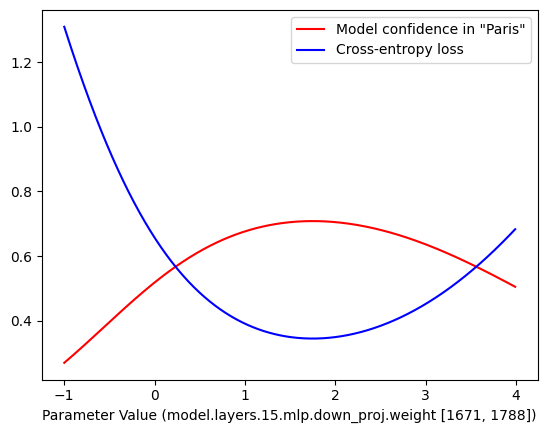

In [26]:
plt.plot(xs, all_probs_2, color='red'); plt.plot(xs, losses_2, color='blue')
plt.legend(['Model confidence in "Paris"', 'Cross-entropy loss'])
plt.xlabel('Parameter Value (model.layers.15.mlp.down_proj.weight [1671, 1788])')

In [27]:
#What paramter value minimizes our loss?
xs[np.argmin(losses_2).item()]

np.float64(1.7500000000000027)

In [28]:
#Set our second parameter to it's optimal value
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][1671, 1788]=1.75

In [29]:
# Now we get into a pickle, let's test our first parameter again
xs=np.arange(-1, 4, 0.01)
model.eval()
losses_b=[]; all_probs_b=[]
with torch.no_grad():
    for x in tqdm(xs):
        param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=x
        outputs = model(inputs["input_ids"])
        probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, -1, 12366])
        losses_b.append(my_loss.item())
        all_probs_b.append(probs[0, -1, 12366].item())

  0%|                                                               | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_2244611/2084474677.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, -1, 12366])
100%|█████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.26it/s]


Text(0.5, 0, 'Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

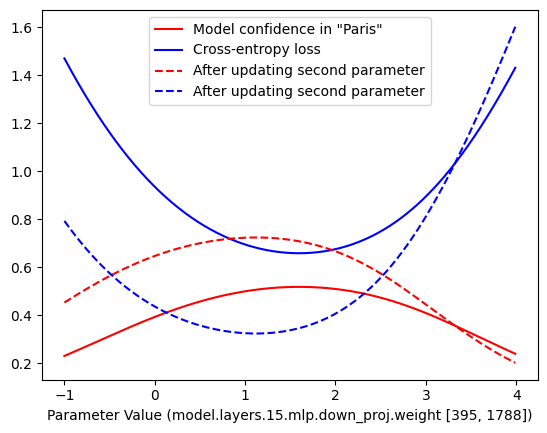

In [30]:
plt.plot(xs, all_probs, color='red'); plt.plot(xs, losses, color='blue')
plt.plot(xs, all_probs_b, 'r--'); plt.plot(xs, losses_b, 'b--')
plt.legend(['Model confidence in "Paris"', 'Cross-entropy loss', 'After updating second parameter', 'After updating second parameter'])
plt.xlabel('Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

In [31]:
# Ah, the shape of our second curve has changed! 
# What value for our first parameter minimizes our loss now?
xs[np.argmin(losses_b).item()]

np.float64(1.1200000000000019)

### 2.4 Explore Loss Landscape For Randomly Initialized Model

In [32]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

In [33]:
import torch
from torch.nn import functional as F
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [34]:
#Only needed for llama random initialization
config_dict = {
  "_attn_implementation_autoset": True,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": False,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": False,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": True,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "use_cache": True,
  "vocab_size": 128256
}

In [35]:
device='cuda'
model_id = "meta-llama/Llama-3.2-1B"

torch.manual_seed(42)
np.random.seed(42)

model_config  = LlamaConfig.from_dict(config_dict)
model = LlamaForCausalLM(model_config).to(device) 
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

In [36]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

100%|███████████████████████████████████████████████████| 4096/4096 [02:26<00:00, 28.03it/s]


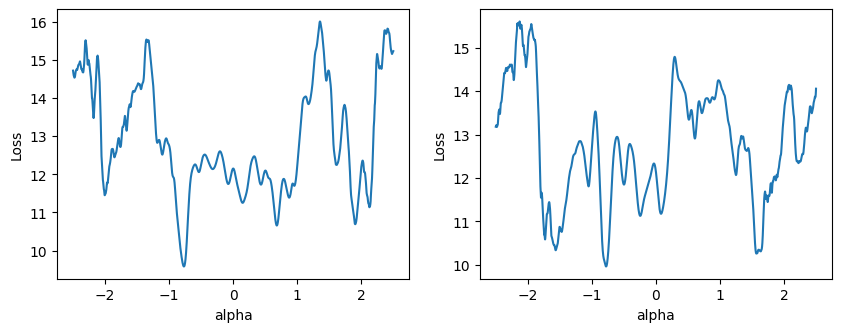

In [37]:
fig=plt.figure(0, (10, 3.5))
for fig_count, random_seed in enumerate([64, 51]):
    filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
    filtered_params = filtered_params[1:] #Leave off embedding layer
    
    direction1 = get_random_directions(filtered_params, seed=random_seed)
    direction1 = normalize_direction(direction1, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    num_points=4096
    alphas=np.linspace(-2.5, 2.5, num_points)
    
    losses=[]
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params[name] + alpha * direction1[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses.append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
    
    fig.add_subplot(1,2,fig_count+1)
    plt.plot(alphas, losses)
    plt.xlabel('alpha'); plt.ylabel('Loss')
    
save_dir='/home/stephen/book_exports'
plt.savefig(save_dir+'/before_training_landscape_slice_'+str(random_seed)+'.svg')

## 2.5 Explore Loss Landscape for Trained Model

In [38]:
import torch
from torch.nn import functional as F
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [39]:
device='cuda'
model_id = "meta-llama/Llama-3.2-1B"

In [40]:
#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

In [41]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

100%|███████████████████████████████████████████████████| 4096/4096 [02:25<00:00, 28.23it/s]


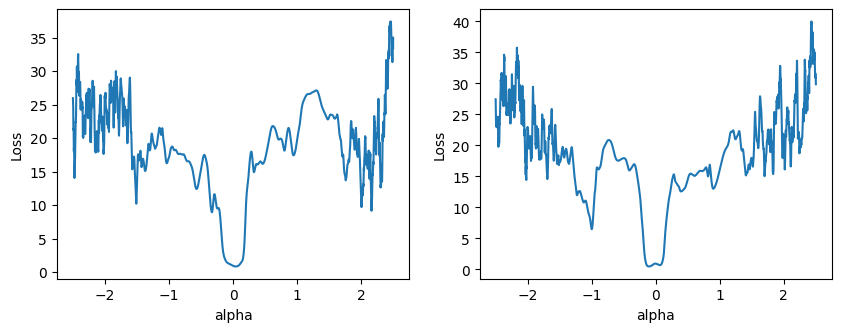

In [42]:
fig=plt.figure(0, (10, 3.5))
for fig_count, random_seed in enumerate([19, 27]):
    filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
    filtered_params = filtered_params[1:] #Leave off embedding layer
    
    direction1 = get_random_directions(filtered_params, seed=random_seed)
    direction1 = normalize_direction(direction1, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    num_points=4096
    alphas=np.linspace(-2.5, 2.5, num_points)
    
    losses=[]
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params[name] + alpha * direction1[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses.append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
    
    fig.add_subplot(1,2,fig_count+1)
    plt.plot(alphas, losses)
    plt.xlabel('alpha'); plt.ylabel('Loss')
    
save_dir='/home/stephen/book_exports'
plt.savefig(save_dir+'/after_training_landscape_slice_'+str(random_seed)+'.svg')

## 2.6 Explore full 2D Landsacpe

In [162]:
import torch
from torch.nn import functional as F
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [44]:
device='cuda'
model_id = "meta-llama/Llama-3.2-1B"

In [45]:
#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

In [46]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

100%|███████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.12s/it]


<Figure size 640x480 with 0 Axes>

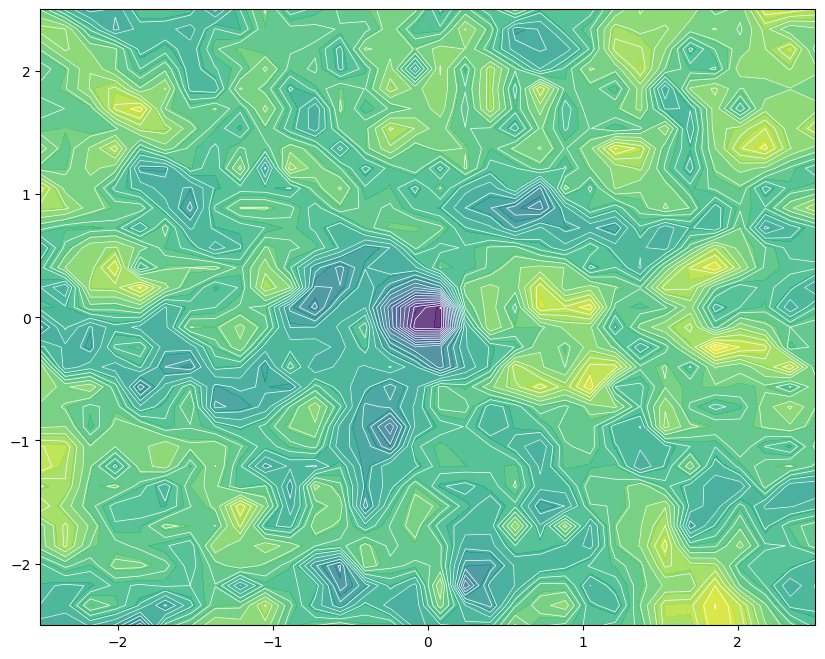

In [47]:
prefix='pretrained_'
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]

layers_name='first_8'
filtered_params = filtered_params[1:73] #First 8 layers - I like this - facorite so far

num_points=32 #Video uses 512, takes a few hours to compute
random_seed_1 = 11
random_seed_2 = 111

# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=random_seed_1)
direction2 = get_random_directions(filtered_params, seed=random_seed_2)

direction1 = normalize_direction(direction1, filtered_params)
direction2 = normalize_direction(direction2, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

alphas=np.linspace(-2.5, 2.5, num_points)
betas=np.linspace(-2.5, 2.5, num_points)
losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        losses.append([])
        for j, beta in enumerate(betas):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params[name] + alpha * direction1[name] + beta*direction2[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses[-1].append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

losses=np.array(losses)

plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)

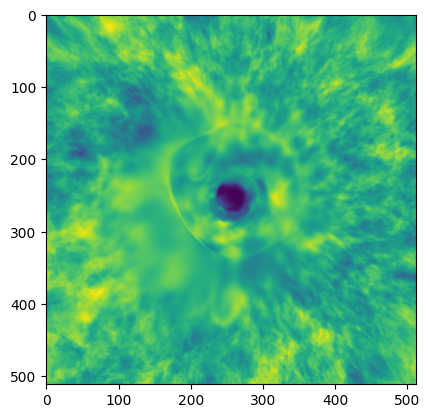

In [48]:
#Alternatively, load up saved hig res (512x512) version
alphas_1=np.linspace(-2.5, 2.5, 512)
betas_1=np.linspace(-2.5, 2.5, 512)
loss_2d_1=np.load('data/loss_landscape.npy')
# plt.imshow(loss_2d_1)

In [49]:
#Take middle slices in each direction of landscape
slice_1=loss_2d_1[255, :]
slice_2=loss_2d_1[:, 255]

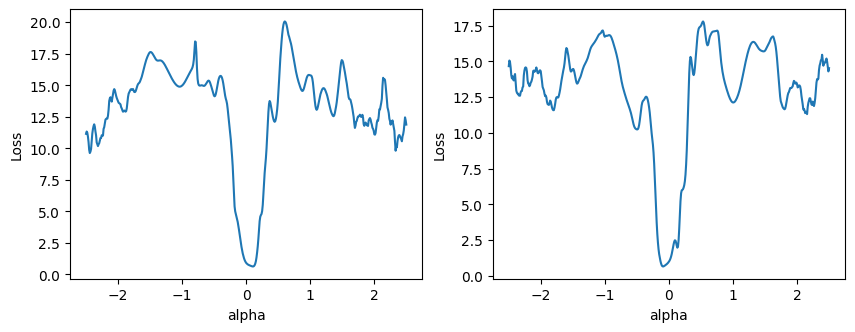

In [50]:
fig=plt.figure(0, (10, 3.5))

fig.add_subplot(1,2,1)
plt.plot(alphas_1, slice_1)
plt.xlabel('alpha'); plt.ylabel('Loss')

fig.add_subplot(1,2,2)
plt.plot(betas_1, slice_2) 
plt.xlabel('alpha'); plt.ylabel('Loss')

save_dir='/home/stephen/book_exports'
plt.savefig(save_dir+'/after_training_landscape_slice_first_8.svg')

<Figure size 640x480 with 0 Axes>

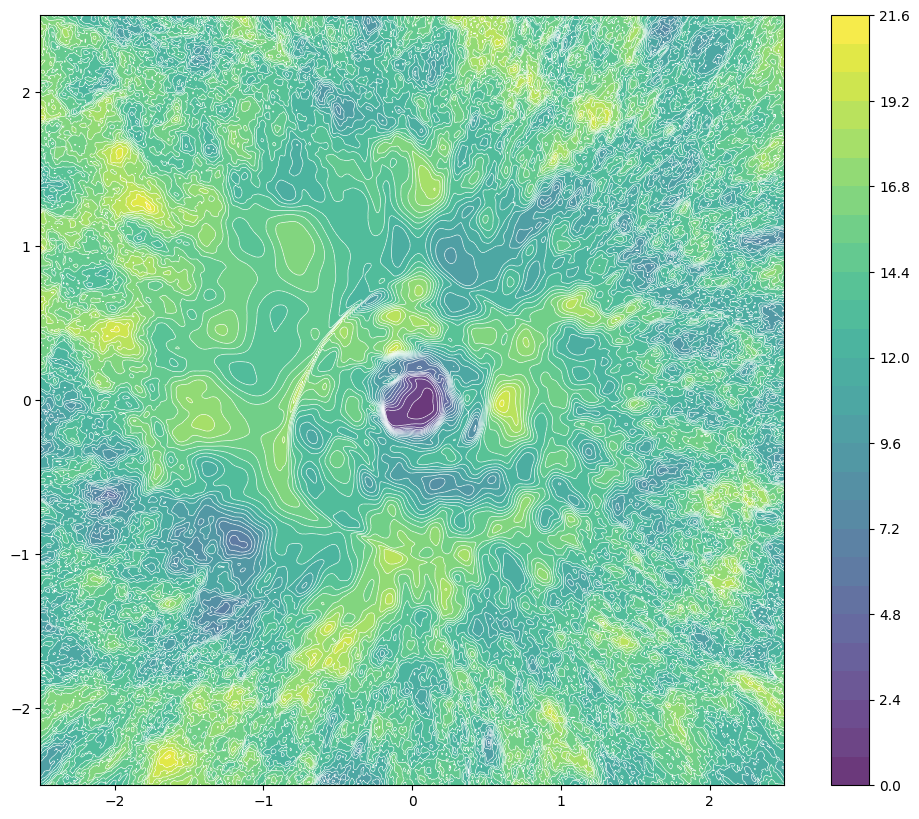

In [51]:
#Loss landscape contour plot
plt.clf()
fig, ax = plt.subplots(figsize=(12, 10))
contourf = ax.contourf(alphas_1, betas_1, loss_2d_1, 30, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas_1, betas_1, loss_2d_1, 30, colors='white', linewidths=0.5)
plt.colorbar(contourf, ax=ax)

# Some figure saving
# save_dir='/home/stephen/book_exports'
# plt.savefig(save_dir+'/landscape_overhead_1.svg')

# plt.clf()
# fig, ax = plt.subplots(figsize=(10, 10))
# contourf = ax.contourf(alphas_1, betas_1, loss_2d_1, 30, cmap='viridis', alpha=0.8)
# contour = ax.contour(alphas_1, betas_1, loss_2d_1, 30, colors='white', linewidths=0.5)
# # plt.colorbar(contourf, ax=ax)
# plt.axis('off')
# save_dir='/home/stephen/book_exports'
# plt.savefig(save_dir+'/landscape_overhead_1.png', dpi=250)

### 2.7 Wormhole
- See seprate notebook for generating landscapes while training

In [165]:
save_dir='/home/stephen/book_exports'

In [166]:
#Alternatively, load up saved hig res (512x512) version
alphas_1=np.linspace(-2.5, 2.5, 512)
betas_1=np.linspace(-2.5, 2.5, 512)

<Figure size 640x480 with 0 Axes>

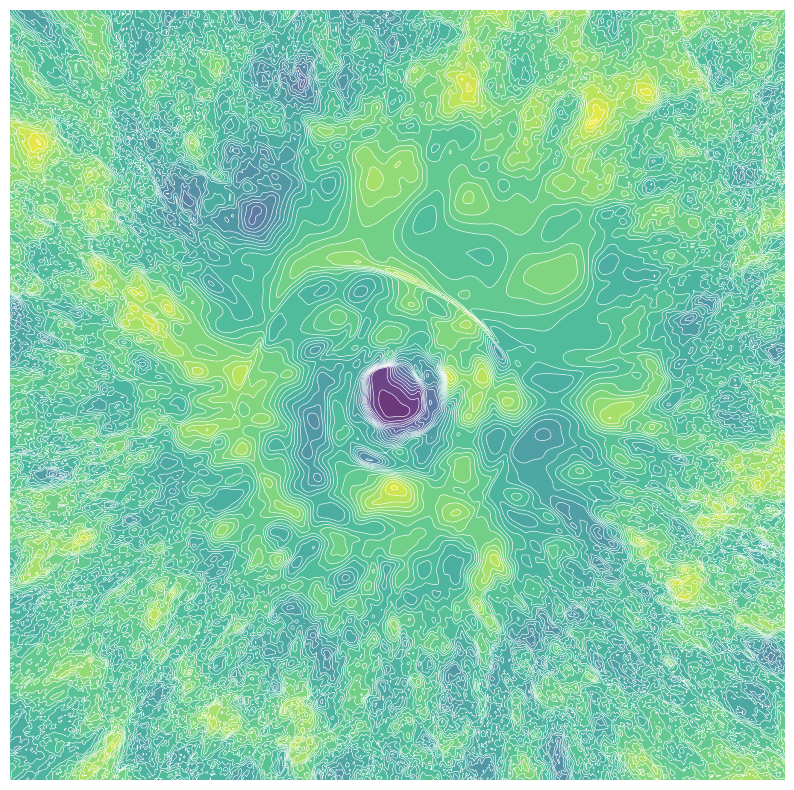

In [167]:
training_step=0
loss_2d_1=np.load('/home/stephen/book_exports/wormhole_merged/'+ str(training_step).zfill(3) +'.npy')
loss_2d_1=np.rot90(loss_2d_1) #Rotate for viz
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
contourf = ax.contourf(alphas_1, betas_1, loss_2d_1, 30, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas_1, betas_1, loss_2d_1, 30, colors='white', linewidths=0.5)
# plt.colorbar(contourf, ax=ax)
# plt.scatter(-0.9, -0.05,c='m', s=10) #, alpha=0.5) #Staring point for optimizer
plt.axis('off')
# plt.grid(color='k')
plt.savefig(save_dir+'/landscape_overhead_2b.png', dpi=250)

<Figure size 640x480 with 0 Axes>

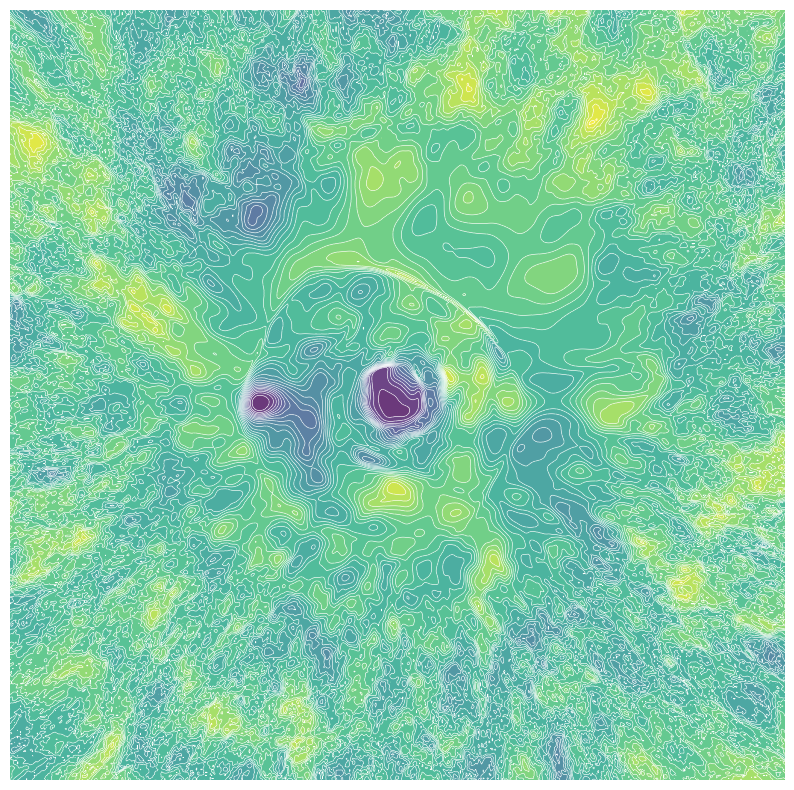

In [124]:
training_step=64
loss_2d_2=np.load('/home/stephen/book_exports/wormhole_merged/'+ str(training_step).zfill(3) +'.npy')
loss_2d_2=np.rot90(loss_2d_2) #Rotate for viz
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
contourf = ax.contourf(alphas_1, betas_1, loss_2d_2, 30, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas_1, betas_1, loss_2d_2, 30, colors='white', linewidths=0.5)
# plt.colorbar(contourf, ax=ax)
plt.axis('off')
# plt.grid(color='k')
plt.savefig(save_dir+'/landscape_overhead_3.png', dpi=250)

### 2D Slice as we Learn

In [1]:
#2D Slices as we learn
fig = plt.figure(0, (12, 5))
cmap = plt.cm.viridis_r

for training_step in range(1,64):
    loss_2d_3 = np.load('/home/stephen/book_exports/wormhole_merged/' + str(training_step).zfill(3) + '.npy')
    loss_2d_3 = np.rot90(loss_2d_3)  # Rotate for viz
    
    # Map training_step to a color in the viridis colormap
    color = cmap(training_step / 63)  # Divide by 63 to get values from 0 to 1
    plt.plot(loss_2d_3[250, :], color=color, alpha=np.clip(0.2 + 0.8 * training_step / 64, 0, 1), linewidth=0.5)

norm = Normalize(vmin=0, vmax=63)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Training Step', rotation=270, labelpad=15)

loss_2d_3 = np.load('/home/stephen/book_exports/wormhole_merged/' + str(0).zfill(3) + '.npy')
loss_2d_3 = np.rot90(loss_2d_3)  # Rotate for viz
plt.plot(loss_2d_3[250, :], color='r', linewidth=2, linestyle=':', alpha=0.8)

loss_2d_3 = np.load('/home/stephen/book_exports/wormhole_merged/' + str(64).zfill(3) + '.npy')
loss_2d_3 = np.rot90(loss_2d_3)  # Rotate for viz
plt.plot(loss_2d_3[250, :], color='c', linewidth=2, linestyle='--', alpha=0.8)
plt.savefig(save_dir+'/slices_while_learning.svg')

NameError: name 'plt' is not defined

### 2.8 Wikitext Example
- Wikitext training code is in manim repo

In [2]:
import torch
from torch.nn import functional as F
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [52]:
data_dir='/home/stephen/book_exports/apr_29_2/'
save_dir='/home/stephen/book_exports'
alphas_1=np.linspace(-2.5, 2.5, 512)
betas_1=np.linspace(-2.5, 2.5, 512)

loss_arrays_pre=[]
loss_arrays_post=[]
loss_arrays_interleaved=[]
num_time_steps=4
for i in tqdm(range(num_time_steps)):
    loss_arrays_pre.append(np.load(data_dir+'pre_step_'+str(i).zfill(3)+'.npy'))
    loss_arrays_post.append(np.load(data_dir+'post_step_'+str(i).zfill(3)+'.npy'))
    loss_arrays_interleaved.append(loss_arrays_pre[-1])
    loss_arrays_interleaved.append(loss_arrays_post[-1])

data_max=np.array(loss_arrays_interleaved).max()

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 433.98it/s]


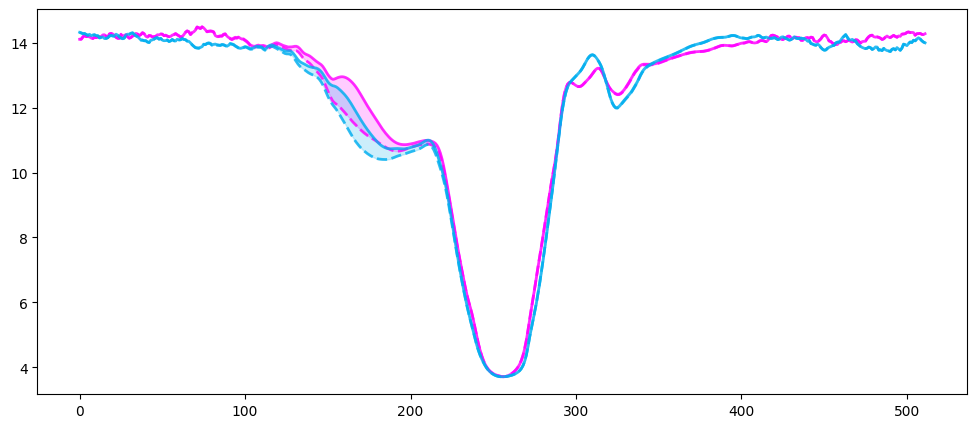

In [53]:
# colors=['#ed1c24', '#00aeef', '#7f3f98', '#00a14b']
colors=['#FF00FF', '#00aeef']
fig=plt.figure(0, (12,5))

for training_index in range(2):
    x = np.arange(150, 220)  # x-axis values
    pre_data = np.rot90(loss_arrays_pre[training_index])[250, :]
    post_data = np.rot90(loss_arrays_post[training_index])[250, :]
    
    # Plot the lines
    plt.plot(pre_data, alpha=0.8, color=colors[training_index], linewidth=2)
    plt.plot(post_data, alpha=0.8, linestyle='--', color=colors[training_index], linewidth=2)
    
    # Shade between the lines
    plt.fill_between(range(len(pre_data)), pre_data, post_data, 
                     color=colors[training_index], alpha=0.2)
    
plt.savefig(save_dir+'/wikitext_slice_1.svg')

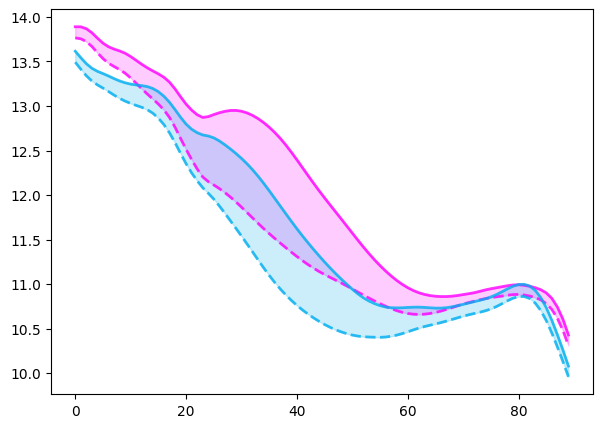

In [54]:
# colors=['#ed1c24', '#00aeef', '#7f3f98', '#00a14b']
colors=['#FF00FF', '#00aeef']
fig=plt.figure(0, (7,5))

for training_index in range(2):
    x = np.arange(150, 220)  # x-axis values
    pre_data = np.rot90(loss_arrays_pre[training_index])[250, 130:220]
    post_data = np.rot90(loss_arrays_post[training_index])[250, 130:220]
    
    # Plot the lines
    plt.plot(pre_data, alpha=0.8, color=colors[training_index], linewidth=2)
    plt.plot(post_data, alpha=0.8, linestyle='--', color=colors[training_index], linewidth=2)
    
    # Shade between the lines
    plt.fill_between(range(len(pre_data)), pre_data, post_data, 
                     color=colors[training_index], alpha=0.2)
plt.savefig(save_dir+'/wikitext_slice_1_zoom.svg')

<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

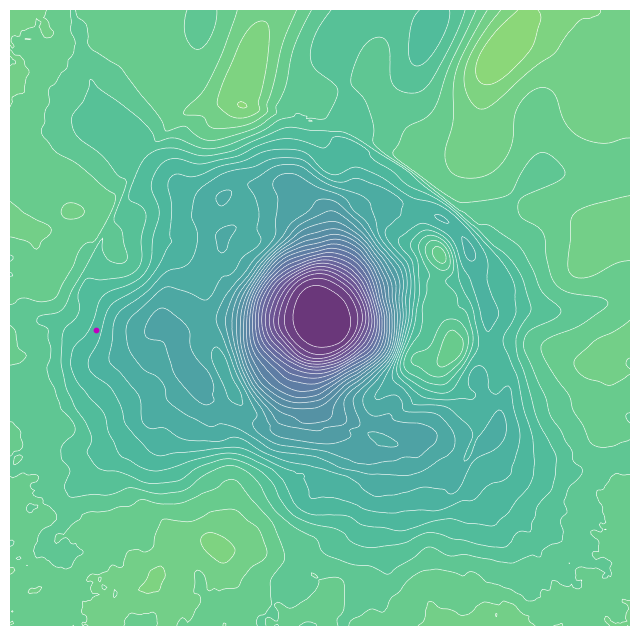

In [61]:
for training_index in range(2):
    loss_to_viz=np.rot90(loss_arrays_pre[training_index]) #Rotate for viz
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    contourf = ax.contourf(alphas_1[128:-128], betas_1[128:-128], loss_to_viz[128:-128, 128:-128], 30, cmap='viridis', alpha=0.8, vmax=1.2*data_max) #Artificial color ceiling to make it not all yellow)
    contour = ax.contour(alphas_1[128:-128], betas_1[128:-128], loss_to_viz[128:-128, 128:-128], 30, colors='white', linewidths=0.5)
    plt.axis('off')
    plt.scatter(-0.9, -0.05,c='m', s=10) #, alpha=0.5) #Staring point for optimizer
    plt.savefig(save_dir+'/wikitext_pre_'+str(training_index)+'.png', dpi=250);

<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

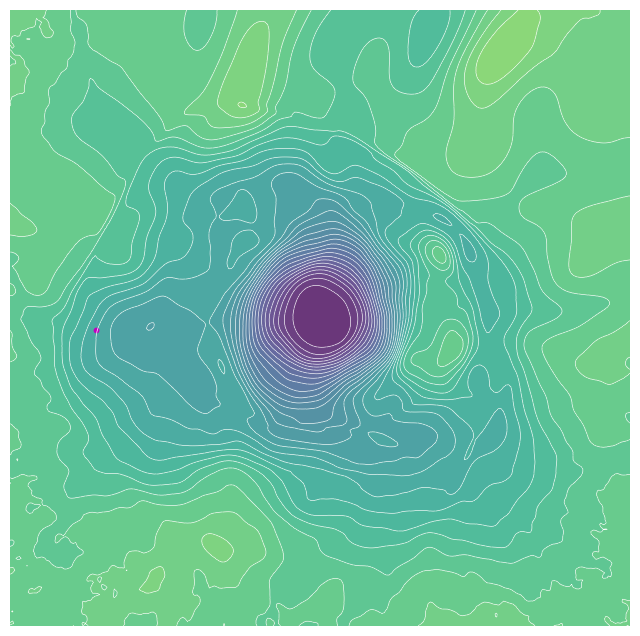

In [63]:
for training_index in range(2):
    loss_to_viz=np.rot90(loss_arrays_post[training_index]) #Rotate for viz
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    contourf = ax.contourf(alphas_1[128:-128], betas_1[128:-128], loss_to_viz[128:-128, 128:-128], 30, cmap='viridis', alpha=0.8, vmax=1.2*data_max) #Artificial color ceiling to make it not all yellow)
    contour = ax.contour(alphas_1[128:-128], betas_1[128:-128], loss_to_viz[128:-128, 128:-128], 30, colors='white', linewidths=0.5)
    plt.scatter(-0.9, -0.05,c='m', s=10) #, alpha=0.5) #Staring point for optimizer
    plt.axis('off')
    plt.savefig(save_dir+'/wikitext_post_'+str(training_index)+'.png', dpi=250);

Definitely some slice action here again!